In [18]:
from keras._tf_keras.keras.models import Sequential, load_model, save_model
from keras._tf_keras.keras.regularizers import L1, L2, L1L2
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.metrics import Accuracy, F1Score, Precision, Recall
from keras._tf_keras.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras._tf_keras.keras.callbacks import Callback
from keras._tf_keras.keras.utils import to_categorical
from sklearn.metrics import classification_report, roc_curve, auc
import keras._tf_keras.keras.datasets as datasets
import keras._tf_keras.keras.layers as layers

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
from PIL import Image

In [13]:
# Adjust HyperParameters

INPUT_SHAPE = (32, 32, 3)
IMAGE_SIZE = 32
EPOCHS = 50
BATCH_SIZE = 32
NUM_CLASSES = 10
LABELS = {0 : 'Airplane',
          1 : 'Automobile',
          2 : 'Bird',
          3 : 'Cat',
          4 : 'Deer',
          5 : 'Dog',
          6 : 'Frog',
          7 : 'Horse',
          8 : 'Ship',
          9 : 'Truck'}

In [15]:
def display_shapes(x_train, y_train, x_test, y_test) -> None:
    print(f"X-Train : {x_train.shape}")
    print(f"Y-Train : {y_train.shape}")
    print(f"X-Test  : {x_test.shape}")
    print(f"Y-Test  : {y_test.shape}")

def display_classes(x : np.ndarray, y : np.ndarray, num_classes : int) -> None:
    plt.figure(figsize=(12, 6))
    for i in range(num_classes):
        class_indices = np.where(y.flatten() == i)[0]
        random_index = np.random.choice(class_indices)
        image = x[random_index]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        try : plt.title(LABELS[i])
        except : plt.title(f"Class No. : {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def display_results(x : np.ndarray, y : np.ndarray, pred : np.ndarray) -> None:
    plt.figure(figsize=(15, 6))
    for i in range(NUM_CLASSES):
        class_indices = np.where(y.flatten() == i)[0]
        random_index = np.random.choice(class_indices)
        image = x[random_index]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(f'Target: {LABELS[i]}, Pred: {LABELS[np.argmax(pred[random_index])]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
X-Train : (50000, 32, 32, 3)
Y-Train : (50000, 1)
X-Test  : (10000, 32, 32, 3)
Y-Test  : (10000, 1)


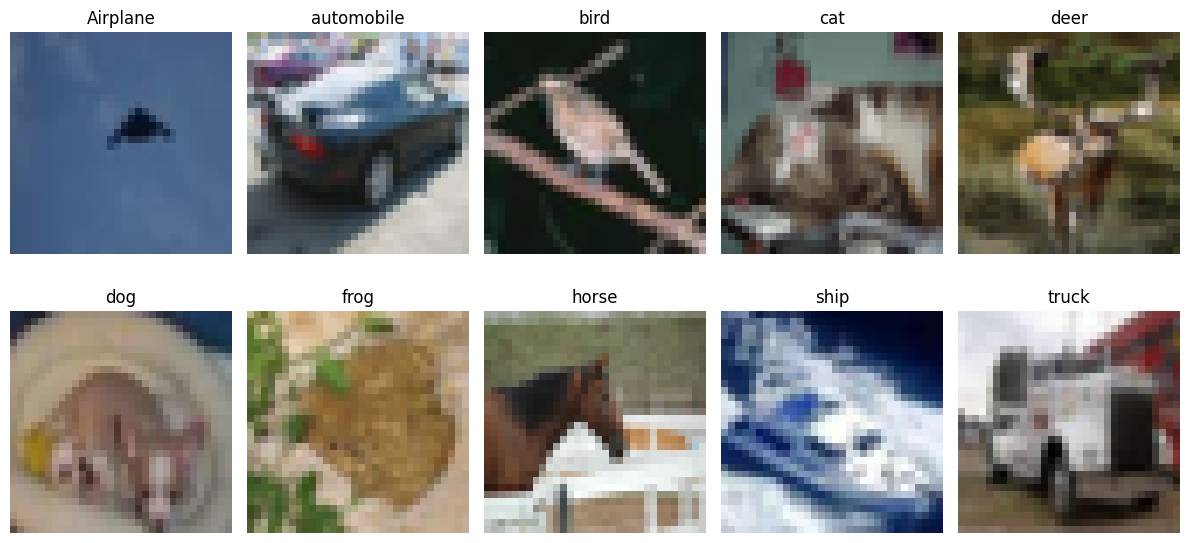

In [4]:
# Initializing The Dataset :

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
display_shapes(x_train, y_train, x_test, y_test)
display_classes(x_train, y_train, num_classes=NUM_CLASSES)



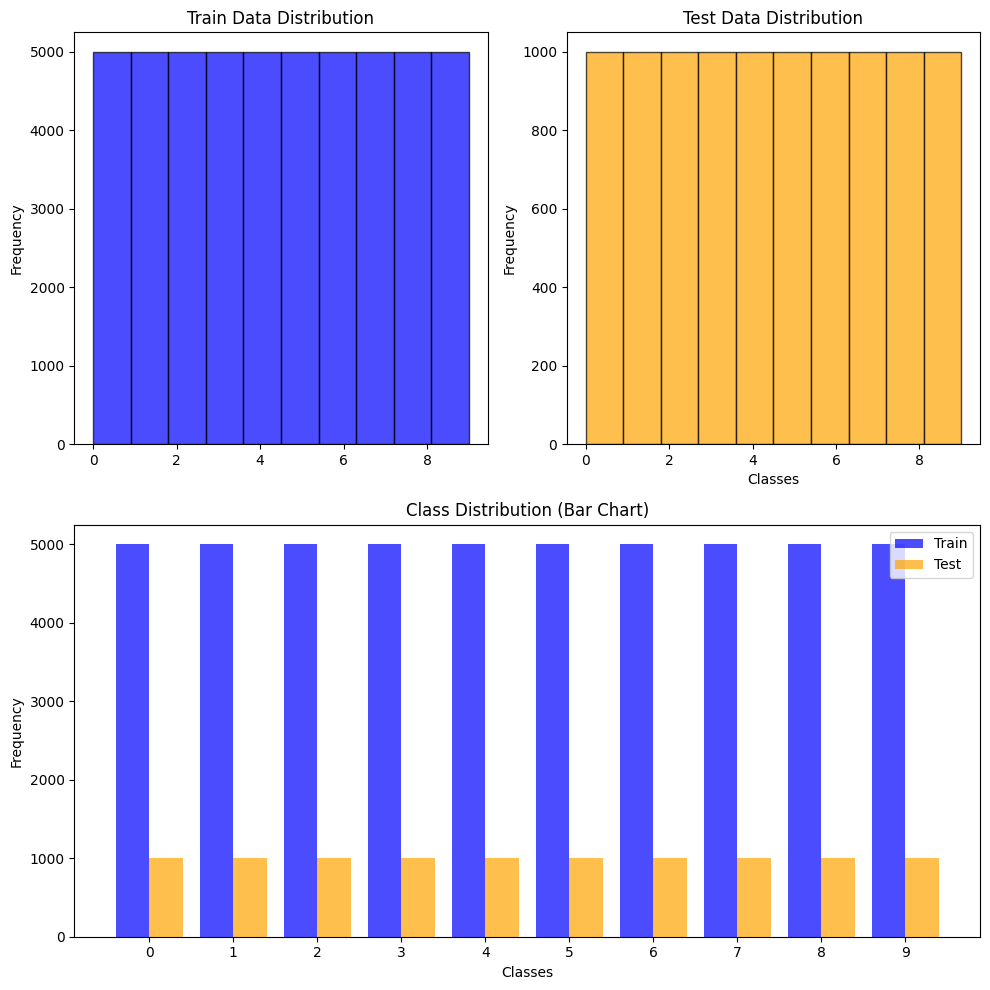

In [33]:
# Analyze Data Distributions :

classes = np.arange(NUM_CLASSES)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title("Train Data Distribution")
plt.hist(y_train, bins=NUM_CLASSES, edgecolor='black', color='blue', alpha=0.7)
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.title("Test Data Distribution")
plt.hist(y_test, bins=NUM_CLASSES, edgecolor='black', color='orange', alpha=0.7)
plt.ylabel('Frequency')
plt.xlabel('Classes')

plt.subplot(2, 1, 2)
train_class_counts = np.bincount(np.ravel(y_train), minlength=NUM_CLASSES)
test_class_counts = np.bincount(np.ravel(y_test), minlength=NUM_CLASSES)
plt.bar(classes - 0.2, train_class_counts, width=0.4, color='blue', alpha=0.7, label='Train')
plt.bar(classes + 0.2, test_class_counts, width=0.4, color='orange', alpha=0.7, label='Test')
plt.xticks(classes)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Distribution (Bar Chart)")
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
# Main Model Structure :

ann = Sequential(name='ANN')

ann.add(layers.Input(shape=INPUT_SHAPE))
ann.add(layers.Flatten())
ann.add(layers.BatchNormalization())

ann.add(layers.Dense(units=2056, activation='relu', name='Dense1'))
ann.add(layers.Dense(units=1024, activation='relu', name='Dense2'))
ann.add(layers.Dense(units=256, activation='relu', name='Dense3'))
ann.add(layers.Dense(units=64, activation='relu', name='Dense4'))
ann.add(layers.Dense(units=32, activation='relu', name='Dense5'))
ann.add(layers.Dense(units=NUM_CLASSES, activation='softmax', name='Out'))


ann.summary()


Model: "ANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3072)                │          12,288 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense1 (Dense)                       │ (None, 2056)                │       6,318,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense2 (Dense)                       │ (None, 1024)                │       2,106,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense3 (Dense)                       │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense4 (Dense)                       │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense5 (Dense)                       │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Out (Dense)                          │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,718,002 (33.26 MB)

 Trainable params: 8,711,858 (33.23 MB)

 Non-trainable params: 6,144 (24.00 KB)

In [6]:
# Model Compile :

ann.compile(optimizer='Adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy', 'f1_score'])


In [7]:
# Fitting The Model :

history = ann.fit(x=x_train,
          y=y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=[x_test, y_test])

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.3056 - f1_score: 0.1954 - loss: 1.9733 - val_accuracy: 0.4380 - val_f1_score: 0.1951 - val_loss: 1.5774
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4385 - f1_score: 0.1955 - loss: 1.5909 - val_accuracy: 0.4776 - val_f1_score: 0.1950 - val_loss: 1.4727
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4920 - f1_score: 0.1955 - loss: 1.4482 - val_accuracy: 0.5062 - val_f1_score: 0.1953 - val_loss: 1.4088
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5300 - f1_score: 0.1956 - loss: 1.3414 - val_accuracy: 0.5188 - val_f1_score: 0.1954 - val_loss: 1.3735
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5613 - f1_score: 0.1956 - loss: 1.2451 - val_accuracy: 0.5332 - val_f1_score: 0.1955 - val_loss: 1.3193
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5929 - f1_score: 0.1956 - loss: 1.1592 - val_accuracy: 0.5411 - val_

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5595 - f1_score: 0.1956 - loss: 2.4355
Loss : 2.3797, Accuracy : 0.5576
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


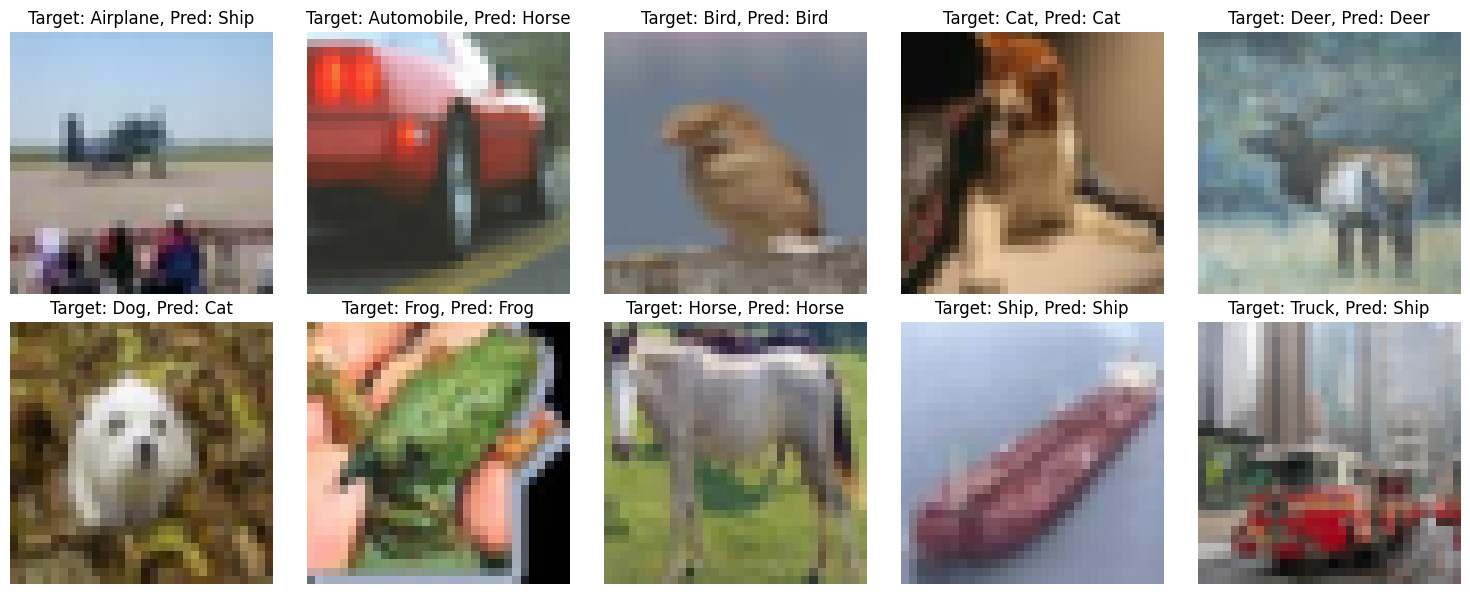

In [16]:
# Evaluating The Model :

items = ann.evaluate(x_test, y_test)

loss = items[0]
accuracy = items[1]

print(f"Loss : {loss:.4f}, Accuracy : {accuracy:.4f}")


pred = ann.predict(x_test)

display_results(x_test, y_test, pred)


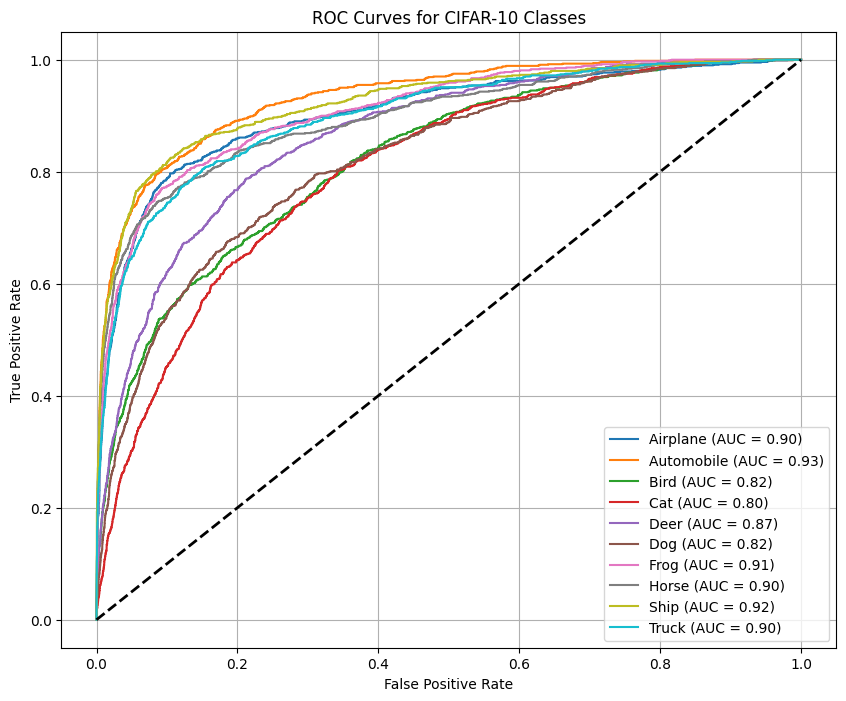

In [19]:
# ROC Curves of Classes :

y_test_onehot = to_categorical(y_test, NUM_CLASSES)

plt.figure(figsize=(10, 8))

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], pred[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{LABELS[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title("ROC Curves for CIFAR-10 Classes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()
